# PSI Numerical Methods 2023, Project 3 (MCMC)

For this assignment, we will look at the efficiency (convergence speed) for four different MCMC approaches:
* plain old Metropolis-Hastings with (uncorrelated) Gaussian jumps, and poorly chosen jump sizes
* Metropolis-Hastings with (uncorrelated) Gaussian jumps, and well chosen jump sizes
* Metropolis-Hastings with correlated Gaussian jumps
* the Affine-invariant ensemble sampler


When you are ready to check in your code, please
* make sure to click the "save" button on the notebook
* In Jupyterhub, open a `Terminal` session
* `cd PSI-MCMC-project`
* `git commit -a -m "update notebook"`
* `git push`

In this notebook, I will highlight your tasks in **bold**.

In [1]:
]add CairoMakie

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using CairoMakie
using LinearAlgebra
using AffineInvariantMCMC
using Statistics
using Printf

We will start by defining the same data and functions that you're probably bored of by now!

In [3]:
# Example data set from  arxiv:1008.4686, table 1 (https://arxiv.org/abs/1008.4686)
# You can also refer to that paper for more background, equations, etc.
alldata = [201. 592 61; 244 401 25; 47  583 38; 287 402 15; 203 495 21; 58  173 15; 210 479 27;
           202 504 14; 198 510 30; 158 416 16; 165 393 14; 201 442 25; 157 317 52; 131 311 16;
           166 400 34; 160 337 31; 186 423 42; 125 334 26; 218 533 16; 146 344 22 ]
# The first 5 data points are outliers; for this we'll just use the "good" data points
x    = alldata[6:end, 1]
y    = alldata[6:end, 2]
# this is the standard deviation (uncertainty) on the y measurements, also known as \sigma_i
yerr = alldata[6:end, 3];

In [4]:
function log_likelihood_one(params, x, y, yerr)
    """This function computes the log-likelihood of a data set with coordinates
    (x_i,y_i) and Gaussian uncertainties on y_i of yerr_i (aka sigma_i)

    The model is a straight line, so the model's predicted y values are
        y_pred_i = b + m x_i.

    params = (b,m) are the parameters (scalars)
    x,y,yerr are arrays (aka vectors)

    Return value is a scalar log-likelihood.
    """
    # unpack the parameters
    b,m = params
    # compute the vector y_pred, the model predictions for the y measurements
    y_pred = b .+ m .* x
    # compute the log-likelihoods for the individual data points
    # (the quantity inside the sum in the text above)
    loglikes = log.(1 ./ (sqrt(2*π) .* yerr)) .- 0.5 .*(y - y_pred).^2 ./ yerr.^2
    # the log-likelihood for the whole vector of measurements is the sum of individual log-likelihoods
    loglike = sum(loglikes)
    return loglike
end;

And here's the "vanilla" Metropolis-Hasting Markov Chain Monte Carlo from the MCMC-filled-in notebook.  Please feel free to use your own if you prefer it!

In [5]:
function mcmc(logprob_func, logprob_args,
              propose_func, propose_args,
              initial_pos, nsteps)
    """
    MCMC: Markov Chain Monte Carlo.  Draw samples from the *logprob_func* probability distribution,
    using proposed moves generated by the function *propose_func*.

    * logprob_func: a function that returns the log-probability at a given value of parameters.
               It will get called like this:
        lnp = logprob_func(params, logprob_args)
    * logprob_args: extra arguments to pass to logprob_func.
    * propose_func: a function that proposes to jump to a new point in parameter space.
               It will get called like this:
        p_new = propose_func(p, propose_args)
    * propose_args: extra arguments to pass to propose_func.
    * initial_pos: initial position in parameter space (list/array)
    * nsteps: integer number of MCMC steps to take
    
    Returns  (chain, faccept)
    * chain: size Nsteps x P, MCMC samples
    * faccept: float: fraction of proposed jumps that were accepted
    """
    p = initial_pos
    logprob = logprob_func(p, logprob_args)
    chain = zeros(Float64, (nsteps, length(p)))
    naccept = 0
    for i in 1:nsteps
        # propose a new position in parameter space
        p_new = propose_func(p, propose_args)
        # compute probability at new position
        logprob_new = logprob_func(p_new, logprob_args)
        # decide whether to jump to the new position
        if exp(logprob_new - logprob) > rand()
            p = p_new
            logprob = logprob_new
            naccept += 1
        end
        # save the position
        chain[i,:] = p
    end
    return chain, naccept/nsteps
end;

Here is the proposal distribution function for the simple (uncorrelated) Gaussian.  The samples from this function will lie in an axis-aligned ellipse.

In [6]:
function propose_gaussian(p, stdevs)
    """
    A Gaussian proposal distribution for mcmc.
    *p*: the point in parameter space to jump from
    *stdevs*: standard deviations for each dimension in the parameter space.
    """
    return p .+ randn(length(p)) .* stdevs
end;

I'm asking you to act like Bayesians, so instead of the log-likelihood we're going to use the log-posterior (but with a flat prior...).

In [7]:
function log_posterior_one(params, args)
    (x, y, yerr) = args
    loglike = log_likelihood_one(params, x, y, yerr)
    # Improper, flat priors on params!
    logprior = 0.
    return loglike + logprior
end;

## Part 1.  Metropolis-Hastings MCMC, with uncorrelated Gaussian jumps and bad jump sizes!

In [8]:
# initial B,M
initial_pos = [0., 1.0]
# proposal distribution: jump sizes for B,M
jump_sizes = [1., 0.1]

# How many MCMC steps to take
nsteps = 5000
# How many samples to throw away as "burn-in"
nburn = 1000

# Run MCMC!
wholechain,accept = mcmc(log_posterior_one, (x,y,yerr),
                         propose_gaussian, jump_sizes,
                         initial_pos, nsteps)
println("Fraction of moves accepted:", accept)
chain = wholechain[nburn+1:end, :]
size(chain)

Fraction of moves accepted:0.3552


(4000, 2)

Now, let's have a look at the convergence.  Looking at the samples for just one of `B` or `M`,
let's compute the mean and standard deviation of all the samples up to different lengths of the
chain.  (Eg, the mean and standard deviation after 1000 steps, then 2000 steps, then 3000 steps.)
If our chain is converging, we should see that the mean and variance do not change much as we take
more samples.

In [9]:
# Measure the mean and standard deviation of array `x` up to index `steps`, `2*steps`, etc.
function running_mean_std(x, steps)
    n = size(x,1)
    # the list of steps that we're going to measure the mean and std up to.
    ss = steps:steps:n
    mn = zeros(size(ss,1))
    st = zeros(size(ss,1))
    for i in 1:size(ss,1)
        mn[i] = mean(x[1:ss[i]])
        st[i] =  std(x[1:ss[i]])
    end
    return ss,mn,st
end;

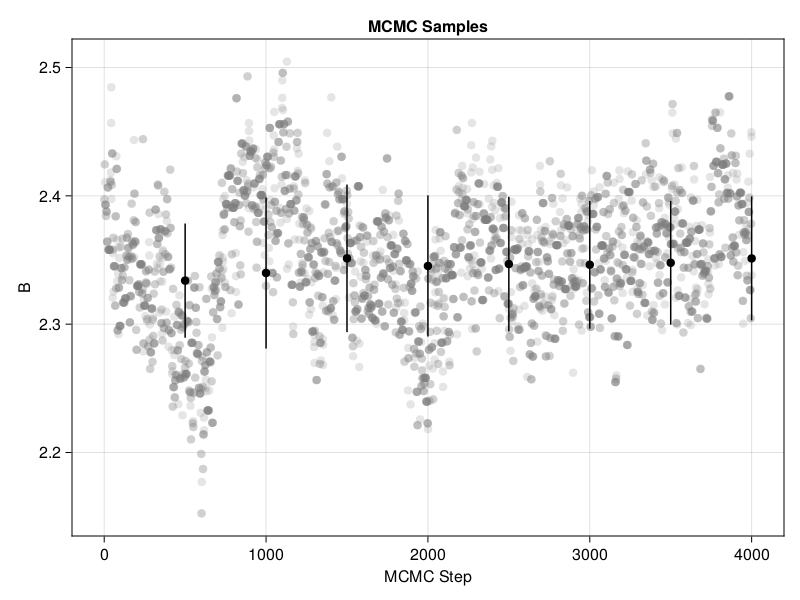

In [10]:
# Plot the parameter values in the chain!
f = Figure()
ax = Axis(f[1, 1], xlabel="MCMC Step", ylabel="B", title="MCMC Samples")
scatter!(chain[:,2], color=(:grey, 0.2), label="Samples")

# Let's measure the running mean and variance after different chain lengths
runsteps = 500
ss,mn,st = running_mean_std(chain[:,2], runsteps)

scatter!(ss, mn, color=:black, label="Mean + Std up to this sample")
errorbars!(ss, mn, st)
#Legend(f[1,2],ax)
f

**Does this chain look like it has converged?**

One way we would use the samples from our MCMC is to report the values, say in a paper we are writing.

**Looking at the numbers in the `mn` and `st` arrays from above (the mean and standard deviation of the first 500 samples, first 1000 samples, first 1500, etc), please write out what you would report for the mean and uncertainty of `M`, in the form $X \pm Y$.  For example, to print them out for the first 500 samples, you could use the code below.  Please write out those values for all the entries in the `mn` and `st` arrays.  If you were writing a paper, you would just use the last entry.  Are you happy with that value, or do you think that if you ran the chain for longer, it would settle on a different final value?**

In [11]:
# mean and standard deviation of the first 500 samples
@printf("\n %.2f +/- %.2f", mn[1], st[1])
# the first 1000 samples
@printf("\n %.2f +/- %.2f", mn[2], st[2])
# the first 1500 samples
@printf("\n %.2f +/- %.2f", mn[3], st[3])

# the first 3000 samples
@printf("\n %.2f +/- %.2f", mn[6], st[6])

# the first 3500 samples
@printf("\n %.2f +/- %.2f", mn[7], st[7])

# the first 4000 samples
@printf("\n %.2f +/- %.2f", mn[8], st[8])


 2.33 +/- 0.04
 2.34 +/- 0.06
 2.35 +/- 0.06
 2.35 +/- 0.05
 2.35 +/- 0.05
 2.35 +/- 0.05

I would conclude that the chain has converged at the mean and uncertainty of $2.31 \pm 0.06$. 

## Part 2.  Metropolis-Hastings MCMC, with uncorrelated Gaussian jumps and good jump sizes!

Please repeat the steps above, but with `jump_sizes` that you found in the tutorial session that resulted in good acceptance fractions.  (If you need to, you can also check later on in the `MCMC-filled-in` notebook!)

Fraction of moves accepted:0.513


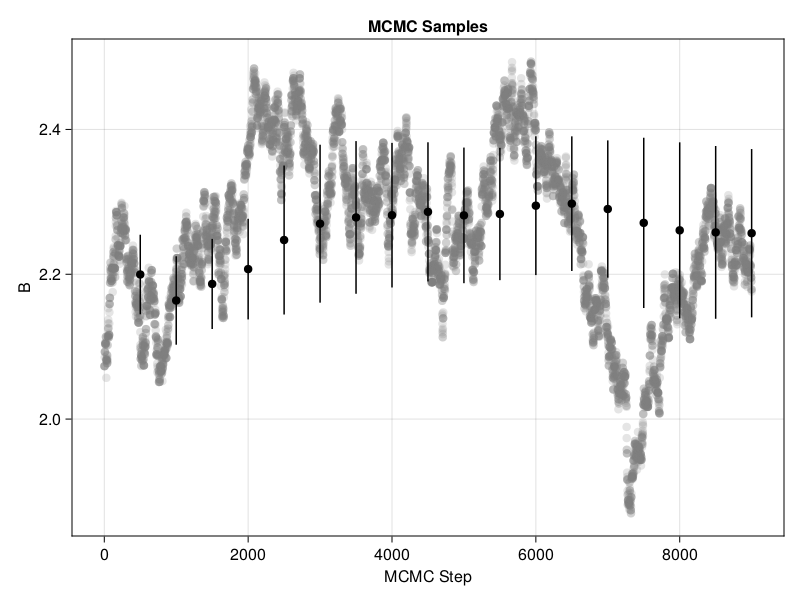

In [12]:
# initial B,M
initial_pos = [0., 1.0]
# proposal distribution: jump sizes for B,M
jump_sizes = [10., 0.01]

# How many MCMC steps to take
nsteps = 10000
# How many samples to throw away as "burn-in"
nburn = 1000

# Run MCMC!
wholechain,accept = mcmc(log_posterior_one, (x,y,yerr),
                         propose_gaussian, jump_sizes,
                         initial_pos, nsteps)
println("Fraction of moves accepted:", accept)
chain = wholechain[nburn+1:end, :]
size(chain)

# Plot the parameter values in the chain!
f = Figure()
ax = Axis(f[1, 1], xlabel="MCMC Step", ylabel="B", title="MCMC Samples")
scatter!(chain[:,2], color=(:grey, 0.2), label="Samples")

# Let's measure the running mean and variance after different chain lengths
runsteps = 500
ss,mn,st = running_mean_std(chain[:,2], runsteps)

scatter!(ss, mn, color=:black, label="Mean + Std up to this sample")
errorbars!(ss, mn, st)
#Legend(f[1,2],ax)
f

**With better step sizes, what do you observe about how much the running mean and standard deviation changes?  Does it look like the chain has converged after 5000 steps?**

In [13]:
# mean and standard deviation of the first 500 samples
@printf("\n %.2f +/- %.2f", mn[1], st[1])
# the first 1000 samples
@printf("\n %.2f +/- %.2f", mn[2], st[2])
# the first 1500 samples
@printf("\n %.2f +/- %.2f", mn[3], st[3])

# the first 3000 samples
@printf("\n %.2f +/- %.2f", mn[6], st[6])

# the first 3500 samples
@printf("\n %.2f +/- %.2f", mn[7], st[7])

# the first 4000 samples
@printf("\n %.2f +/- %.2f", mn[8], st[8])

# the first 6000 samples
@printf("\n %.2f +/- %.2f", mn[12], st[12])

# the first 6500 samples
@printf("\n %.2f +/- %.2f", mn[13], st[13])

# the first 7000 samples
@printf("\n %.2f +/- %.2f", mn[14], st[14])

# the first 7500 samples
@printf("\n %.2f +/- %.2f", mn[15], st[15])

# the first 8000 samples
@printf("\n %.2f +/- %.2f", mn[16], st[16])

# the first 8500 samples
@printf("\n %.2f +/- %.2f", mn[17], st[17])

# the first 9000 samples
@printf("\n %.2f +/- %.2f", mn[18], st[18])


 2.20 +/- 0.05
 2.16 +/- 0.06
 2.19 +/- 0.06
 2.27 +/- 0.11
 2.28 +/- 0.11
 2.28 +/- 0.10
 2.29 +/- 0.10
 2.30 +/- 0.09
 2.29 +/- 0.09
 2.27 +/- 0.12
 2.26 +/- 0.12
 2.26 +/- 0.12
 2.26 +/- 0.12

The mean and uncertainty have not completely converged after 5000 steps (with first 1000 burnt). But they did converge after 10000 steps (with first 1000 burnt) to $2.21 \pm 0.11$.

## Part 3.  Metropolis-Hastings MCMC, with correlated Gaussian jumps and good jump sizes!

In the first two parts, we are using the `propose_gaussian` function to propose the jumps to take.  That function takes an array of two standard deviations, one for the `B` direction and one for the `M` direction.  It draws two random Gaussian values and multiplies one by the `B` step size and the other by the `M` step size.  This results in a proposal ellipse that is axis-aligned in the `B`, `M` plane.

In this part, I want you to write a proposal function that proposes jumps in the `B,M` plane that are Gaussian distributed but with a covariance between the `B` and `M` values, so that the proposals are inclined in the `B,M` plane, approximately matching the shape of the likelihood contours.

We are going to *cheat* a bit by using the `chain` computed above to define our proposal distribution!

In [14]:
# We will take the "chain" computed above and compute its covariance using the cov() function.
C = cov(chain)

2×2 Matrix{Float64}:
 371.081    -2.15642
  -2.15642   0.0135067

This is the covariance matrix between `M` and `B`.  The diagonals are the variances of the individual variables -- we know that `B` has a larger spread of allowed values, so its variance is larger than the variance of `M`.  The covariance term, which is symmetric, is negative -- the variables are *anti-*correlated.

**Please complete the `propose_gaussian_cov` function below, and confirm that it works by drawing 1000 samples centered on point `(0,0)` and confirming that the covariance is approximately equal to the desired covariance (C), and plot the samples and confirm that they are strongly anti-correlated.**

In [41]:
function propose_gaussian_cov(p, cov)
    """
    A Gaussian proposal distribution for mcmc, that draws samples with covariance = *cov*.
    
    That is, it draws samples from the multivariate Gaussian.
    
    *p*: the point in parameter space to jump from
    *cov*: the covariance between the points
    """

    # Hint: You will probably want to draw two independent regular Gaussian samples and then matrix-multiply them by something!
    g_sample = randn(length(p))

    A = LinearAlgebra.cholesky(cov)
    return  p .+ A.L * g_sample # Cholesky decomposition is like finding the square root of the covariance matrix, L is a lower triangular matrix

end;

(Hint: "sample from gaussian covariance" is a pretty good Google search phrase!  Another hint: you have the *covariance*
but you want to multiply your independent Gaussian samples by something that is like the *matrix square root* of the covariance!)

In [42]:
# To test your `propose_gaussian_cov` function, you can try drawing 1,000 samples from it, centered on (0,0) :

pp = Float64[]
for i in 1:1000
    append!(pp, propose_gaussian_cov([0.,0.], C))
end
pp = reshape(pp, 2,:)';

**Compute the covariance of the samples generated by your function.  Do they match the desired covariance, C?**

In [43]:
cov(pp)

2×2 Matrix{Float64}:
 369.518    -2.13775
  -2.13775   0.0133144

Observe that the values matched C. 

**Plot the samples generated by your function.  Are they an inclined ellipse with the expected larger scatter in B than in M?

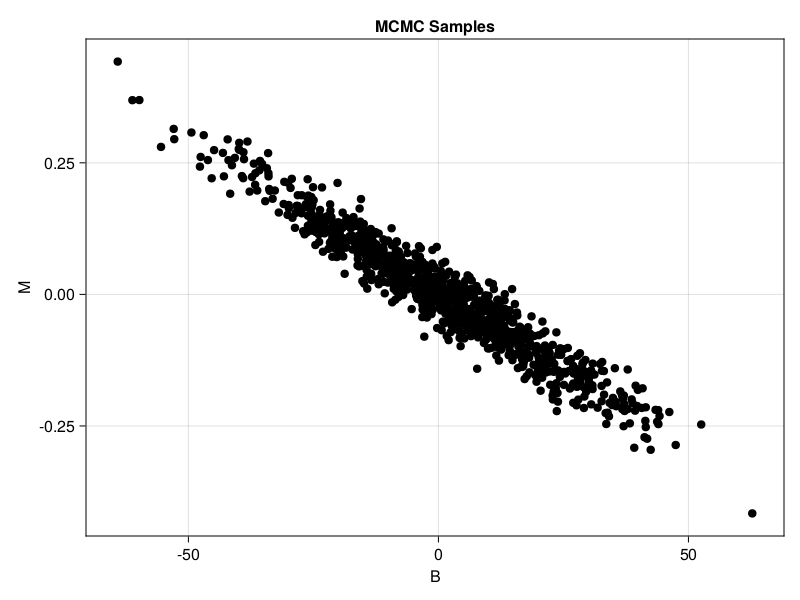

In [44]:
f = Figure()
Axis(f[1, 1], xlabel="B", ylabel="M", title="MCMC Samples")
plot!(pp[:,1], pp[:,2])
f

Observe that the generated samples form an inclined ellipse with the expected larger scatter in B than in M.

FINALLY, let's run the MCMC algorithm using your new proposal function (and the target covariance matrix)!

In [45]:
# initial B,M
initial_pos = [0., 1.0]
# Run MCMC!
chain,accept = mcmc(log_posterior_one, (x,y,yerr),
                    propose_gaussian_cov, C,
                    initial_pos, nsteps)
println("Fraction of moves accepted:", accept)
chain = chain[nburn+1:end, :]
size(chain)

Fraction of moves accepted:0.5374


(9000, 2)

**Repeat the plots we made in Part 1 and compare the results.  Does it look like this chain is converged after 5,000 steps?  Did the burn-in take the same amount of steps, or was it maybe slower or faster?**

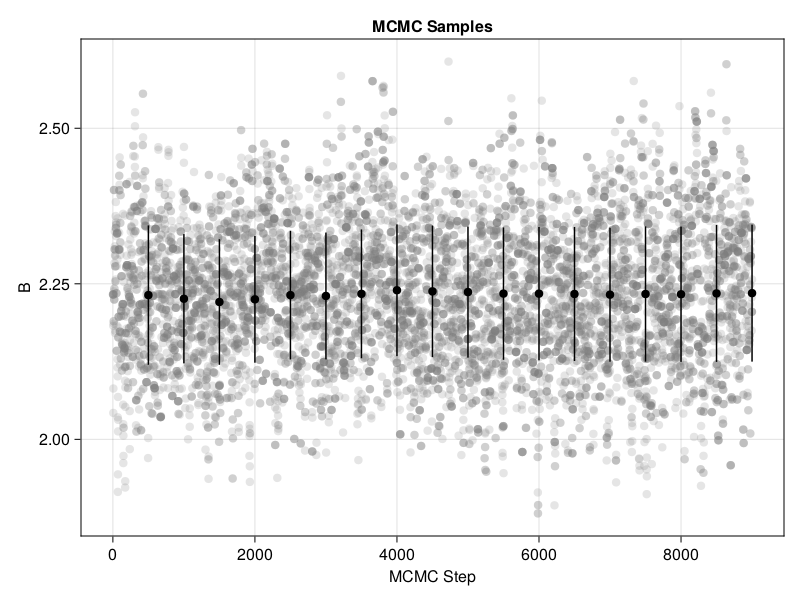

In [46]:
# Plot the parameter values in the chain!
f = Figure()
ax = Axis(f[1, 1], xlabel="MCMC Step", ylabel="B", title="MCMC Samples")
scatter!(chain[:,2], color=(:grey, 0.2), label="Samples")

# Let's measure the running mean and variance after different chain lengths
runsteps = 500
ss,mn,st = running_mean_std(chain[:,2], runsteps)

scatter!(ss, mn, color=:black, label="Mean + Std up to this sample")
errorbars!(ss, mn, st)
#Legend(f[1,2],ax)
f

In [48]:
# mean and standard deviation of the first 500 samples
@printf("\n %.2f +/- %.2f", mn[1], st[1])
# the first 1000 samples
@printf("\n %.2f +/- %.2f", mn[2], st[2])
# the first 1500 samples
@printf("\n %.2f +/- %.2f", mn[3], st[3])

# the first 3000 samples
@printf("\n %.2f +/- %.2f", mn[6], st[6])

# the first 3500 samples
@printf("\n %.2f +/- %.2f", mn[7], st[7])

# the first 7000 samples
@printf("\n %.2f +/- %.2f", mn[14], st[14])


 2.23 +/- 0.11
 2.23 +/- 0.10
 2.22 +/- 0.10
 2.23 +/- 0.10
 2.23 +/- 0.10
 2.23 +/- 0.11

The chain has converged very fast (around 1000 samples), which means we don't need to burn in as many steps as we did previously. 

## Part 4.  The Affine-invariant sampler.

In this part, we'll use the affine-invariant ensemble sampler.

Since the ensemble sampler moves a *group* of *walkers* at once, we have to be a bit careful how we compare it to regular MCMC.  Probably the fairest comparison is if you make the total number of samples the same.  That is, run the ensemble sampler for `n_ensemble = n_mcmc / n_walkers` where `n_mcmc` was the number of steps you took in the regular MCMC chain.

You may see, however, that the burn-in takes longer.  So you might want to either initialize the ensemble closer to the correct answer, or run for more burn-in steps.


In [49]:
# We need to tell the sampler a number of things:
# - how many dimensions are being sampled
numdims = 2
# - how many walkers we want
numwalkers = 25
# In the example code below, it runs an initial "burn-in" round of sampling, then does the "real" sampling.  This is how many
# burn-in samples to take.
nburn_aff = nburn ÷ numwalkers
# - how many steps to take (after burn-in)
nsteps_aff = (nsteps - nburn) ÷ numwalkers

# We also need to give the walkers some initial positions.  NOTE that you can't give them all the same position!
# Here, we're just drawing uniform numbers of between 0 and 1.
x0 = rand(numdims, numwalkers)
### FILL ME IN -- maybe you want to initialize the walkers around some better point?
# x0[:,1] += ...?
# x0[:,2] += ...?

# We need to pass to the sampler a function that takes *only* the vector of parameters.  Our log_posterior_one function
# also needs the (x,y,yerr) values.  So to make this work, we need a "wrapper" function to can grab the (x,y,yerr) values
# and pass them to log_likelihood_one.

ll_func(bm) = log_posterior_one(bm, (x, y, yerr))

# Here we go, let's call the AffineInvariant MCMC's "sample" function -- this is the burn-in round!
chain, _ = AffineInvariantMCMC.sample(ll_func, numwalkers, x0, nburn_aff, 1)

# And here's the "real" run.
# Notice that it's passing in the end of the burn-in chain as the initial position!
chain, llvals = AffineInvariantMCMC.sample(ll_func, numwalkers, chain[:, :, end], nsteps_aff, 1)

# And that's it!  Now "chain" contains our samples!
println("Chain:", size(chain))

Chain:(2, 25, 360)


In [50]:
# We can "flatten" that list of samples so that it's a (N x 2) array like for regular MCMC.
flatchain, flat_llvals = AffineInvariantMCMC.flattenmcmcarray(chain, llvals);
chain = flatchain'

9000×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -2.35504   1.9579
 -3.61072   2.3176
 17.804     2.31931
  0.101735  2.40171
  1.58284   2.4231
 -2.03271   2.46072
  7.1258    2.39432
  6.03376   2.43612
 -2.37436   2.34866
  0.957397  2.413
 -0.705368  2.45608
  0.913804  2.13599
 -7.69118   2.5013
  ⋮         
 33.0185    2.24374
 43.1146    2.18513
 23.1811    2.29266
  3.45658   2.36917
 51.5315    2.13942
 37.5301    2.26164
  5.17599   2.39562
 20.1142    2.31902
 59.8289    2.07448
 16.3424    2.30604
 21.65      2.26709
 38.8973    2.19344

**Now please repeat the plots and the $M = mean \pm std$ printing from Part 1.  Does it look like the ensemble sampler is converging faster?  Does the burn-in look faster or slower?**

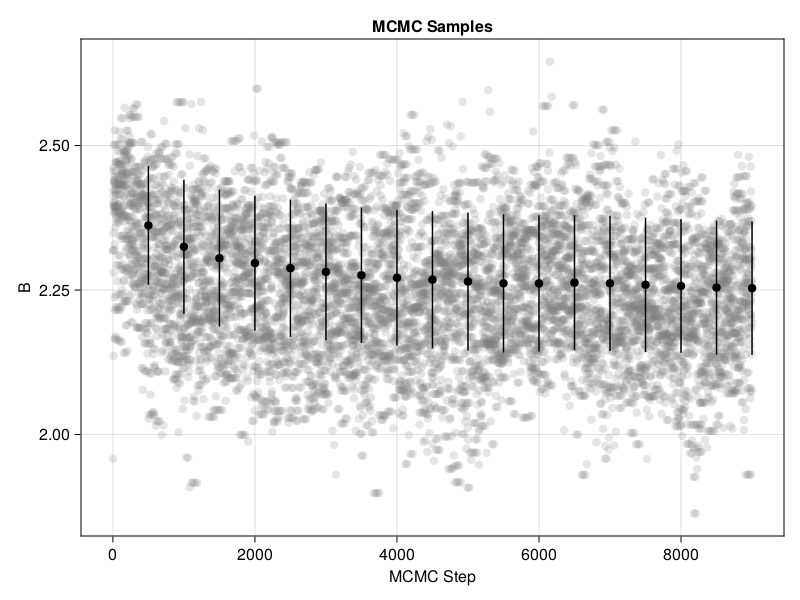

In [51]:
# Plot the parameter values in the chain!
f = Figure()
ax = Axis(f[1, 1], xlabel="MCMC Step", ylabel="B", title="MCMC Samples")
scatter!(chain[:,2], color=(:grey, 0.2), label="Samples")

# Let's measure the running mean and variance after different chain lengths
runsteps = 500
ss,mn,st = running_mean_std(chain[:,2], runsteps)

scatter!(ss, mn, color=:black, label="Mean + Std up to this sample")
errorbars!(ss, mn, st)
#Legend(f[1,2],ax)
f

In [52]:
# mean and standard deviation of the first 500 samples
@printf("\n %.2f +/- %.2f", mn[1], st[1])
# the first 1000 samples
@printf("\n %.2f +/- %.2f", mn[2], st[2])
# the first 1500 samples
@printf("\n %.2f +/- %.2f", mn[3], st[3])

# the first 3000 samples
@printf("\n %.2f +/- %.2f", mn[6], st[6])

# the first 3500 samples
@printf("\n %.2f +/- %.2f", mn[7], st[7])

# the first 7000 samples
@printf("\n %.2f +/- %.2f", mn[14], st[14])


 2.36 +/- 0.10
 2.32 +/- 0.12
 2.31 +/- 0.12
 2.28 +/- 0.12
 2.28 +/- 0.12
 2.26 +/- 0.12

The convergence is faster than the methods in parts 1 and 2, but slower than the methods in part 3. 

**Try changing the number of walkers.  Try 10, or 100.  How do the burn-in and convergence speed look?  Of 10, 20, or 100 walkers, which one looks best to you?**

Let's try 100 walkers. 

Chain:(2, 100, 90)


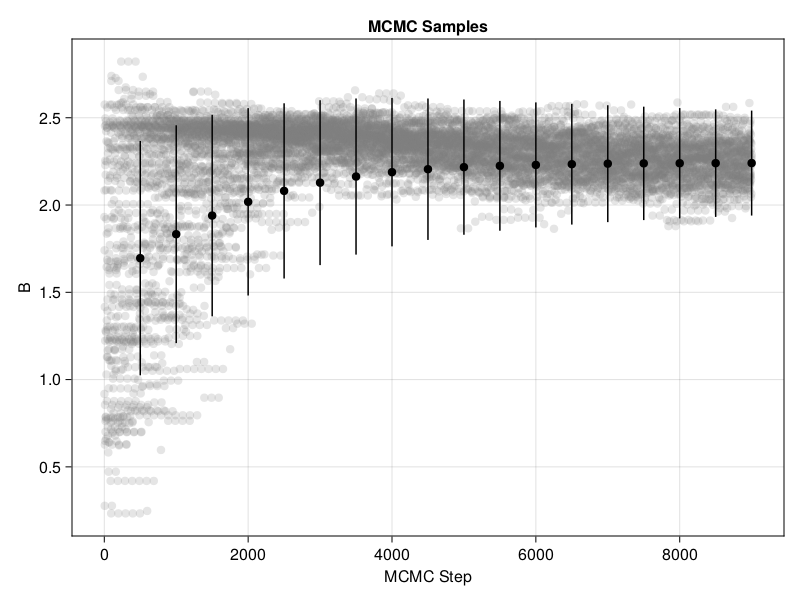

In [54]:
# We need to tell the sampler a number of things:
# - how many dimensions are being sampled
numdims = 2
# - how many walkers we want
numwalkers = 100
# In the example code below, it runs an initial "burn-in" round of sampling, then does the "real" sampling.  This is how many
# burn-in samples to take.
nburn_aff = nburn ÷ numwalkers
# - how many steps to take (after burn-in)
nsteps_aff = (nsteps - nburn) ÷ numwalkers

# We also need to give the walkers some initial positions.  NOTE that you can't give them all the same position!
# Here, we're just drawing uniform numbers of between 0 and 1.
x0 = rand(numdims, numwalkers)
### FILL ME IN -- maybe you want to initialize the walkers around some better point?
# x0[:,1] += ...?
# x0[:,2] += ...?

# We need to pass to the sampler a function that takes *only* the vector of parameters.  Our log_posterior_one function
# also needs the (x,y,yerr) values.  So to make this work, we need a "wrapper" function to can grab the (x,y,yerr) values
# and pass them to log_likelihood_one.

ll_func(bm) = log_posterior_one(bm, (x, y, yerr))

# Here we go, let's call the AffineInvariant MCMC's "sample" function -- this is the burn-in round!
chain, _ = AffineInvariantMCMC.sample(ll_func, numwalkers, x0, nburn_aff, 1)

# And here's the "real" run.
# Notice that it's passing in the end of the burn-in chain as the initial position!
chain, llvals = AffineInvariantMCMC.sample(ll_func, numwalkers, chain[:, :, end], nsteps_aff, 1)

# And that's it!  Now "chain" contains our samples!
println("Chain:", size(chain))

# We can "flatten" that list of samples so that it's a (N x 2) array like for regular MCMC.
flatchain, flat_llvals = AffineInvariantMCMC.flattenmcmcarray(chain, llvals);
chain = flatchain'


# Plot the parameter values in the chain!
f = Figure()
ax = Axis(f[1, 1], xlabel="MCMC Step", ylabel="B", title="MCMC Samples")
scatter!(chain[:,2], color=(:grey, 0.2), label="Samples")

# Let's measure the running mean and variance after different chain lengths
runsteps = 500
ss,mn,st = running_mean_std(chain[:,2], runsteps)

scatter!(ss, mn, color=:black, label="Mean + Std up to this sample")
errorbars!(ss, mn, st)
#Legend(f[1,2],ax)
f

In [57]:
# mean and standard deviation of the first 500 samples
@printf("\n %.2f +/- %.2f", mn[1], st[1])
# the first 1000 samples
@printf("\n %.2f +/- %.2f", mn[2], st[2])
# the first 1500 samples
@printf("\n %.2f +/- %.2f", mn[3], st[3])

# the first 3000 samples
@printf("\n %.2f +/- %.2f", mn[6], st[6])

# the first 3500 samples
@printf("\n %.2f +/- %.2f", mn[7], st[7])

# the first 5000 samples
@printf("\n %.2f +/- %.2f", mn[10], st[10])

# the first 6000 samples
@printf("\n %.2f +/- %.2f", mn[12], st[12])

# the first 7000 samples
@printf("\n %.2f +/- %.2f", mn[14], st[14])


 1.70 +/- 0.67
 1.83 +/- 0.62
 1.94 +/- 0.58
 2.13 +/- 0.47
 2.16 +/- 0.45
 2.22 +/- 0.39
 2.23 +/- 0.36
 2.24 +/- 0.33

Observe that increasing the number of walkers to 100 gives us a greater variance, the convergence also didn't happen as fast. The process becomes more stochastic. 

The End!  Good work!